# Data Wrangling - Assignment 1

- **Winning Commune:** Romoos
- **Neighbors:** Hergiswil bei Willisau, Hasle

## 0. Setup

All required modules from `./requirements.txt` are installed in the current venv and imported.

In [8]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
import json
from pathlib import Path
from shutil import rmtree
from typing import Dict, List, Tuple

import requests
import folium
import geopandas
import numpy as np
import cv2 as cv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import MultiPolygon
from shapely.ops import transform
from bs4 import BeautifulSoup

%matplotlib inline
sns.set_theme()

## 1. Fetching Data and Preprocessing

The raw data is downloaded from the sources listed below. After fetching the data several preprocessing steps are applied for all data sources.

If `FETCH_DATA` is set to `True`, the raw data from previous executions will be deleted and all data is then fetched again. Since URLs and APIs or the data itself might change, it is suggested to set `FETCH_DATA = False` and use the persisted data in `./raw_data/`. The persisted raw data can also be downloaded from [GitHub](https://github.com/RobinfRoth/dawr-ass1/releases/download/data/raw_data.zip) and manually placed in in the `./raw_data/` folder. If you manually place the raw data in the directory make sure all paths in the cell below exist.

### Sources

The data used throughout this Notebook has been obtained form the following sources:

| Data                      | Source                         | URL                                                                                      | Filetype  | Access Date |
|:---                       |:---                            |:---                                                                                      | :---      | :--- |
| Basic Data on Communes <br>(from 2021)    | Bundesamt für Statistik        | https://dam-api.bfs.admin.ch/hub/api/dam/assets/15864450/master                          | XLSX File | 01.03.2025 |
| Coat of Arms of Communes  | Staatsarchiv Kanton Luzern     | https://staatsarchiv.lu.ch/kantonsgeschichte/gemeinden/Gemeindewappen/*\[commune\]*      | JPG Files | 05.03.2025 | 
| Points of Interest (Restaurants) | Overpass API (OpenStreetMap)      | https://overpass-api.de/api/interpreter  | JSON | 17.03.2025 |
| Number of Dogs per Commune | Team Tierstatistik Identitas AG (via OpenData)    | https://tierstatistik.identitas.ch/data/dogs-map-commune.csv <br> https://opendata.swiss/de/dataset/hunde-verteilung-pro-gemeinde                           | CSV File  | 10.03.2025 |
| Spatial data (boundaries) for communes in Switzerland <br>(from 2021) | Bundesamt für Landestopografie (swisstopo); <br> Geojson created by cividi based on the swisstopo data  | https://github.com/cividi/ch-municipalities  | geojson File | 19.03.2025 |

The data from all sources has been downloaded and persisted on the 21.03.2025. 



In [10]:
FETCH_DATA = False

# Directories
RAW_DATA_PATH = Path().cwd() / 'raw_data'
COAT_OF_ARMS_PATH = RAW_DATA_PATH / 'coat_of_arms'
MAP_PATH = RAW_DATA_PATH / 'map'

# Files
COMMUNES_PATH = RAW_DATA_PATH / 'communes.xlsx'
POI_PATH = MAP_PATH / 'restaurants.json'
BOUNDARIES_PATH = MAP_PATH / 'communes.geojson'
DOGS_PATH = RAW_DATA_PATH / "dogs.csv"

In [11]:
def delete_raw_data(raw_data_dir: Path, subdirs: List[Path]) -> None:
    '''
    Deletes all raw data if the raw data directory exists.

    Parameters
    ----------
    raw_data_dir : Path
        The path of the directory that contains the raw data.
    subdirs : List[Path]
        A list of subdirs as an absolute path to create inside the raw data directory.

    Returns
    -------
    None
    '''
    if raw_data_dir.exists():
        rmtree(raw_data_dir)
    
    raw_data_dir.mkdir()

    for dir in subdirs:
        dir.mkdir()

In [12]:
if FETCH_DATA:
    delete_raw_data(RAW_DATA_PATH, [COAT_OF_ARMS_PATH, MAP_PATH])

### 1.1. Base Data: XLSX File for Data on all Comunes

First, an XLSX file with base data on all communes is fetched.

#### 1.1.1. Fetch XLSX File

In [13]:
def download_binary_file(url: str, destination_file: Path) -> None:
    '''
    Downloads a file from a given URL via a HTTP GET request.

    Parameters
    ----------
    url : str
        The URL of the file.
    destination_dir : Path
        The path of the file in which the binary data should be stored.
    
    Returns
    -------
    None
    '''
    request = requests.get(url)
    request.raise_for_status()

    with open(destination_file, "wb") as f:
        f.write(request.content)

In [14]:
if FETCH_DATA:
    bfs_url = 'https://dam-api.bfs.admin.ch/hub/api/dam/assets/15864450/master'
    download_binary_file(bfs_url, destination_file=COMMUNES_PATH)

#### 1.1.2. Preprocess XLSX File

After downloading the file, the following preprocessing steps are applied using pandas:

- Improving column names
    - remove unnecessary word separators: `Bevölkerungs-dichte` => `Bevölkerungsdichte`
    - footnotes are removed: `Gesamtfläche in km² 1)` => `Gesamtfläche in km²`
- Removing rows that represent Switzerland instead of a commune
- Communes in a certain [BFS number](https://en.wikipedia.org/wiki/Community_Identification_Number#Switzerland) range are selected. Here those for the canton of lucerne.
- Removing unnecessary canton identifiers in the commune names: `Hasle (LU)` => `Hasle`

In [15]:
def preprocess_communes_df(raw_communes: pd.DataFrame, min_bfs_nr: int, max_bfs_nr: int) -> Tuple[pd.DataFrame, Dict[int, str]]:
    '''
    Applies the preprocessing steps to the raw communes DataFrame.

    Parameters
    ----------
    raw_communes : DataFrame
        The raw DataFrame after loading from an excel file.
    min_bfs_nr : int
        The BFS number
        (`see Wikipedia <https://en.wikipedia.org/wiki/Community_Identification_Number#Switzerland>`_)
        of the first commune to include in the preprocessed DataFrame.
    max_bfs_nr : int
        The BFS number of the last commune to include in the preprocessed
        DataFrame (The commune with this number will be included in the
        preprocessed DataFrame).
    
    Returns
    -------
    communes : pd.DataFrame
        The complete preprocessed DataFrame.
    communes_names : dict
        A DataFrame that contains only the names of the communes in the
        the range of BFS numbers passed to this function.
    '''
    
    # Improve column names by removing:
    # - unnecessary '-' characters
    # - unnecessary footnotes like '1)'
    raw_communes.rename(
        columns=lambda name: name.replace('-', '') if 'Jahre' not in name else name,
        inplace=True
    )
    raw_communes.rename(
        columns = {
            raw_communes.columns[14]: raw_communes.columns[14][:-3],
            raw_communes.columns[32]: raw_communes.columns[32][:-3],
        },
        inplace=True
    )

    # drop rows that have nan as the index
    # -> in this case this is the Switzerland column which does not have a BFS Nr.  
    raw_communes.drop(labels=np.nan, axis=0, inplace=True)
    raw_communes.set_index(raw_communes.index.astype('int'), inplace=True)

    # select communes, that have BFS numbers in the given range
    communes = raw_communes.loc[min_bfs_nr:max_bfs_nr]

    # Remove the (LU) suffix present for some communes
    communes.loc[:, 'Gemeindename'] = communes.loc[:, "Gemeindename"].str.replace(
        r'(?P<name>\w+) \(LU\)',
        lambda m: m.group('name'),
        regex=True,
    )

    communes_names = communes.loc[:, 'Gemeindename'].sort_values().to_dict()
    return communes, communes_names

Details on loading the excel file:
- The header and footer are ignored
- `Gemeindecode` (the BFS number is used as the index)

Note: The BFS number range for the Canton of Lucerne is 1001 to 1151.

In [16]:
communes = pd.read_excel(
    COMMUNES_PATH,
    skiprows=[0, 1, 2, 3, 4, 6, 7],
    skipfooter=16,
    index_col=0,
)

communes_lu, communes_lu_names = preprocess_communes_df(
    raw_communes=communes,
    min_bfs_nr=1001,
    max_bfs_nr=1151,
)

### 1.2. Additional Data: Gemeindewappen

As a second data source, the coat of arms of the communes is downloaded. 

#### 1.2.1. Fetch JPG Files

The images are fetched from the website of Staatsarchiv Luzern. To following steps are taken:
- Adjusting the names of the communes to fit the url pattern of the Website
- Extract the image URL from the HTML page
- Download the image and store it under the name `[Gemeindecode].jpg`

In [17]:
def download_coat_of_arms(source_url: str, destination_dir: Path, commune_names: Dict[int, str], logging: bool=False) -> None:
    '''
    Downloads images of all coats of arms from Staatsarchiv Luzern.

    Edge Cases:
    - For communes that have a combined name like "Escholzmatt-Marbach" the
    coat of arms of the first commune is fetched.
    - For a multi-word name like "Hergiswil bei Willisau" only the first word
    is used to fetch the coat of arms.

    Parameters
    ----------
    source_url : str
        The URL to download the images from.
    destination_dir : Path
        The Path of the directory where the coats of arms should be stored.
    commune_names : dict
        A dict that matches all BFS numbers of the communes to their names.
    logging : bool, Optional
        If True, logging messages will be printed. Defaults to False.
    
    Returns
    -------
    None
    '''
    # fetch images of coat of arms for all communes
    for cid, commune in commune_names.items():
        # handle concatenated and multi-word commune names
        if '-' in commune:
            commune = commune.split('-')[0]
        elif ' ' in commune:
            commune = commune.split(' ')[0]
        # The coat of arms of 'Willisau' is stored under 'Willisau-Stadt'
        # in https://staatsarchiv.lu.ch
        elif commune == 'Willisau':
            commune = 'Willisau-Stadt'

        current_url = source_url + commune
        if logging:
            print(f'Fetching {current_url}')
        request = requests.get(current_url)
        request.raise_for_status()

        soup = BeautifulSoup(request.text, 'html.parser')
        img = soup.find(id='maincontent_1_imgImage')
        img_url = 'https://staatsarchiv.lu.ch' + img.get('src')

        img_request = requests.get(img_url)
        img_request.raise_for_status()

        current_img_path = destination_dir / f'{cid}.jpg'
        with open(current_img_path, "wb") as f:
            f.write(img_request.content)

In [18]:
if FETCH_DATA:
    sa_lu_url = 'https://staatsarchiv.lu.ch/kantonsgeschichte/gemeinden/Gemeindewappen/'
    download_coat_of_arms(
        sa_lu_url, COAT_OF_ARMS_PATH,
        communes_lu_names, logging=True
    )

### 1.3. Additional Data: Points of Interest - Restaurants

As the third data source, the location (Point of Interest) of all restaurants in the Canton of Lucerne are downloaded.

#### 1.3.1. Fetch Restaurants from OpenStreetMap

To fetch the data from OpenStreetMap, the following steps are used:
- An OverpassQL query to get all Restaurants in the Bounding Box of the canton of Lucerne is passed to
the [OverpassAPI](https://overpass-api.de) in the body of a POST-Request
- The Response is stored as a JSON file.

Additionally, the boundaries of all communes in Switzerland are fetch from [GitHub - Cividi](https://github.com/cividi/ch-municipalities), since
the are more accurate the the ones from gadm.org.

In [19]:
def download_points_of_interest(source_url: str, destination_file: Path, amenity: str) -> None:
    '''
    Downloads a JSON file containing Points of Interest which belong to a ``amenity`` from
    the OpenStreetMap API (OverpassAPI) using a HTTP POST request. The coordinate
    reference system used is WGS 84 (`EPSG:4326<https://epsg.io/4326>`_) .

    Parameters
    ----------
    source_url : str
        The URL to download the restaurant points from.
    destination_dir : Path
        The Path of the directory where the downloaded data should be stored.
    amenity : str
        Which amenity should be fetched from OpenStreetMap. See `OpenStreetMap Wiki
        <https://wiki.openstreetmap.org/wiki/Key:amenity>`_ for a list of all
        possible values.
    
    Returns
    -------
    None
    '''

    # OverpassQL query to get all restaurants in the bounding box of canton lucerne
    payload = {
        'data': f'''
        [out:json]
        [timeout:90]
        ;
        node
            ["amenity"="{amenity}"]
            (46.771849614677,7.8318786621094,47.283887179484,8.514404296875);
        out;
        '''
    }

    # Fetch data from OverpassAPI
    request = requests.post(source_url, data=payload)
    request.raise_for_status()

    with open(destination_file, 'wt', encoding='utf-8') as f:
        f.write(request.text)

In [20]:
def download_text_file(url: str, destination_file: Path) -> None:
    '''
    Downloads a text file from the given ``url`` via a HTTP GET request.

    Parameters
    ----------
    url : str
        The URL of the file.
    destination_file : Path
        The path of the file in which the data should be stored.
    Returns
    -------
    None
    '''
    request = requests.get(url)
    request.raise_for_status()

    with open(destination_file, "wt") as f:
        f.write(request.text)

In [21]:
if FETCH_DATA:
    osm_api_url = 'https://overpass-api.de/api/interpreter'
    boundaries_url = 'https://github.com/cividi/ch-municipalities/releases/download/v0.2/gemeinden.geojson'
    download_points_of_interest(
        source_url=osm_api_url,
        destination_file=POI_PATH,
        amenity='restaurant'
    )
    download_text_file(boundaries_url, BOUNDARIES_PATH)

#### 1.3.2 Preprocess Points of Interest JSON and Commune Boundaries from geojson

After downloading the POIs an the Geojson, the following preprocessing steps are applied:

1. The downloaded geojson file for the commune boundaries contains metadata (e.g. the name of the canton), which is used to only get the boundaries
for the Canton of Lucerne. The filtered data is returned as a JSON string, making it suitable for use as input in Folium as well.
2. Count for every commune, how many restaurant POIs are within its area.
3. Execute final preprocessing steps
    - Rename columns to fit the ones of the base data
    - Use `Gemeindecode` as the index


In [22]:
def filter_geojson_for_lu(geojson_file: Path) -> str:
    '''
    Filters out all data from a ``geojson_file`` that is not about
    communes in the canton of lucerne.

    Parameters
    ----------
    geojson_file : pathlib.Path
        The path pointing to the original geojson, which needs
        to be filtered.
    
    Returns
    -------
    str
        A geojson string containing the data for canton lucerne.
    '''
    # Load json for CH
    with open(geojson_file) as f:
        gadm_json = json.load(f)

    # Only keep communes of canton lucerne
    gadm_communes_lu = filter(
        lambda f: f['properties']['kanton.NAME'] == 'Luzern',
        gadm_json['features']
    )

    # remove dot from key names, since folium cannot handle it
    gadm_json['features'] =  list(gadm_communes_lu)

    return json.dumps(gadm_json)

def get_points_within_area(area: MultiPolygon, poi_df: geopandas.GeoDataFrame):
    '''
    Count how many points of interest there are within the `area` of a commune.

    Parameters
    ----------
    area : MultiPolygon
        The area of a commune as a shapely MultiPolygon.
    poi_df : geopandas.GeoDataFrame
        A GeoDataFrame containing the points in geometry column called
        `Point`.

    Returns
    -------
    int
        The number of points that are within the `area`.
    '''
    return poi_df.loc[:, "Point"].apply(lambda p: p.within(area)).sum()

def count_restaurants_per_commune(restaurant_pois_file: Path, geojson_file: Path) -> geopandas.GeoDataFrame:
    '''
    Counts the number of restaurants per commune using the restaurant
    POIs from a JSON file and the commune area from a geojson file.

    Parameters
    ----------
    restaurant_pois_file : pathlib.Path
        A json file downloaded from OpenStreetMap that contains
        the points of interest for restaurants.
    geojson_file : pathlib.Path
        A geojson file, which contains area data for communes in
        Switzerland.

    Returns
    -------
    geopandas.GeoDataFrame
        A geopandas DataFrame containing the number of restaurants
        per commune, as well as the area of the commune as a polygon.
    rest_df : geopandas.GeoDataFrame
        A geopandas GeoDataFrame containing the locations of the restaurants
    '''
    with open(restaurant_pois_file) as f:
        poi_json = json.load(f)

    # Create Restaurants GeoDataFrame
    restaurants = list(map(lambda e: [ e['tags']['amenity'],
                           Point(e['lat'], e['lon']) ], poi_json['elements']))
    rest_df = geopandas.GeoDataFrame(
        restaurants,
        columns=['Amenity', 'Point'],
        geometry='Point',
        crs='EPSG:4326'
    )

    # Load geojson as GeoDataFrame
    geojson_lu = filter_geojson_for_lu(geojson_file)
    communes_lu_area_df = geopandas.read_file(geojson_lu)
    
    # reverse coordinates to lat, lon format and ignore Z coordinate
    communes_lu_area_df["geometry"] = communes_lu_area_df.loc[:, "geometry"].apply(
        lambda polygon: transform(lambda x, y, _: (y, x), polygon)
    )

    # count points within each commune area
    communes_lu_area_df['Restaurant_count'] = communes_lu_area_df.loc[:, 'geometry'].apply(
        get_points_within_area,
        args=(rest_df,)
    )

    return communes_lu_area_df.copy(), rest_df

def preprocess_restaurant_df(input_df: pd.DataFrame) -> pd.DataFrame:
    '''
    Applies preprocessing (renaming columns, set index) to the ``input_df``, which
    contains the restaurant counts, so that it can be merged with the base data.

    Parameters
    ----------
    input_df : pd.DataFrame
        A pandas DataFrame that contains the restaurant count and
        metadata like BFS-Nr or name for each commune.

    Returns
    -------
    pd.DataFrame
        The preprocessed DataFrame.
    '''

    # Rename columns
    input_df.rename(
        columns={
            'gemeinde.BFS_NUMMER': 'Gemeindecode',
            'gemeinde.NAME': 'Gemeindename',
            'Restaurant_count': 'Anzahl Restaurants',
        },
        inplace=True
    )
    
    # set index
    input_df.set_index('Gemeindecode', drop=True, inplace=True)

    return input_df.copy()

In [25]:
df_communes_area, restaurant_locations = count_restaurants_per_commune(POI_PATH, BOUNDARIES_PATH)

df_rest_count = preprocess_restaurant_df(
    df_communes_area.loc[:,['gemeinde.BFS_NUMMER',
                            'gemeinde.NAME',
                            'Restaurant_count']
    ]
)
df_rest_count.head()

,Gemeindename,Anzahl Restaurants
Gemeindecode,,
1001,Doppleschwand,1
1002,Entlebuch,7
1004,Flühli,10
1005,Hasle,4
1007,Romoos,5


### 1.4. Additional Data: Dogs per Commune

As a fourth data source the number of dogs per commune is downloaded.

#### 1.4.1. Download CSV File

In [28]:
if FETCH_DATA:
    dogs_url = 'https://tierstatistik.identitas.ch/data/dogs-map-commune.csv'
    download_text_file(dogs_url, DOGS_PATH)

#### 1.4.2. Preprocess CSV file

After downloading the CSV-File the following preprocessing steps are applied:
- Adjusting the column names to fit those of the base data
- Removing unused columns
- Removing the `(LU)` suffix from commune names
- Select only those communes that are present in the base data. Information on additional communes which are not in the base dataset will be ignored.
- Map the `Gemeindecode` to the Name of the communes
- Set the index

In [29]:
def preprocess_dog_df(raw_dogs: pd.DataFrame, commune_names: Dict[int, str]) -> Tuple[pd.DataFrame, Dict[int, str]]:
    '''
    Applies the preprocessing steps to the raw dogs DataFrame.

    Parameters
    ----------
    raw_dogs : DataFrame
        The raw DataFrame after loading from an csv file.
    commune_names : Dict[int, str]
        A dictionary mapping each commune's BFS number to its name.
        Only dog counts for communes included in this dictionary will
        be considered.
    Returns
    -------
    dogs : pd.DataFrame
        The complete preprocessed DataFrame.
    '''
    
    new_dog_df = raw_dogs.rename(
        columns = {
            'commune': 'Gemeindename',
            'countPerSurfacekm2': 'Anzahl Hunde pro km2',
            'countPer100Inhabitants': 'Anzahl Hunde pro 100 Einwohner',
            'count': 'Anzahl Hunde',
        }
    )

    new_dog_df.drop(['top5breeds', 'top5names'], axis=1, inplace=True)

     # Remove the LU suffix present for some communes
    new_dog_df.loc[:, 'Gemeindename'] = new_dog_df.loc[:, "Gemeindename"].str.replace(
        r'(?P<name>\w+) \(LU\)',
        lambda m: m.group('name'),
        regex=True,
    )

    # select only select dog data for communes from the list
    dogs_lu = new_dog_df.loc[new_dog_df.loc[:, 'Gemeindename'].isin(commune_names.values())].copy()
    
    # add BFS number as index
    name2nr = { name : nr for nr, name in commune_names.items() } 
    dogs_lu['Gemeindecode'] = dogs_lu.loc[:, 'Gemeindename'].apply(lambda name : name2nr[name])
    
    dogs_lu.set_index('Gemeindecode', inplace=True, drop=True)
    dogs_lu.sort_values(by='Gemeindecode', inplace=True)

    return dogs_lu

In [37]:
dogs = pd.read_csv(DOGS_PATH, sep=';', skiprows=1)

# Check if Honau is a part of the raw dog dataset - spoiler: it is not
display(dogs.loc[dogs["commune"] == 'Honau'])

# Manually add Honau, which is not present in the original dog data
honau_row = pd.DataFrame(
    {'commune': 'Honau',
     'count': 30,
     'countPerSurfacekm2': 30 / communes_lu.at[1057, "Gesamtfläche in km²"],
     'countPer100Inhabitants': (30 / communes_lu.at[1057, "Einwohner"]) * 100,
     'top5breeds':np.nan,
     'top5names': np.nan
    },
    index=[dogs.shape[0]])
dogs = pd.concat([dogs, honau_row])

df_dogs = preprocess_dog_df(dogs, communes_lu_names)
df_dogs

,commune,count,countPerSurfacekm2,countPer100Inhabitants,top5breeds,top5names


,Gemeindename,Anzahl Hunde,Anzahl Hunde pro km2,Anzahl Hunde pro 100 Einwohner
Gemeindecode,,,,
1001,Doppleschwand,57.0,8.2,6.9
1002,Entlebuch,340.0,6.0,10.0
1004,Flühli,159.0,1.5,8.7
1005,Hasle,165.0,4.1,9.2
1007,Romoos,128.0,3.4,19.6
...,...,...,...,...
1145,Ufhusen,93.0,7.6,9.9
1146,Wauwil,128.0,43.2,4.9
1147,Wikon,150.0,18.1,9.9


As shown above, the commune Honau is not in included in the dog dataset, since on 1 January 2025 the commune of Honau merged into the commune of Root. The number of dogs is assumed to be 30, because a [this](https://www.luzernerzeitung.ch/zentralschweiz/luzern/in-diesen-gemeinden-gibt-es-am-meisten-hunde-ld.2210663) article from 2021 mentions this number of dogs for Honau. The other data for honau is calculated manually using the the base data.

## 2. Feature Extraction

After the preprocessing, the all relevant features from the data sources are extracted. 

### 2.1. Extract Relevant Features from communes file

Only a part of the columns from the base data is used:


In [38]:
base_data = communes_lu.iloc[:, [0, 1, 3, 5, 6, 7, 14, 15, 17, 19, 29, 30]]
base_data

,Gemeindename,Einwohner,Bevölkerungsdichte pro km²,0-19 Jahre,20-64 Jahre,65 Jahre und mehr,Gesamtfläche in km²,Siedlungsfläche in %,Landwirtschaftsfläche in %,Wald und Gehölze in %,Leerwohnungsziffer,Neu gebaute Wohnungen pro 1000 Einwohner
Gemeindecode,,,,,,,,,,,,
1001,Doppleschwand,789,113.525180,26.742712,58.681876,14.575412,6.95,5.755396,55.683453,36.115108,1.704545,1.272265
1002,Entlebuch,3280,57.644991,21.798780,59.664634,18.536585,56.90,3.686151,49.552396,42.829559,1.092896,8.446456
1004,Flühli,1929,17.833041,21.876620,60.290306,17.833074,108.17,2.497918,44.527708,38.236655,1.052150,5.112474
1005,Hasle,1736,43.066237,22.695853,59.907834,17.396313,40.31,3.248202,49.094967,39.573518,2.241594,17.694064
1007,Romoos,659,17.625033,22.003035,59.787557,18.209408,37.39,2.088353,35.796519,60.803213,0.874636,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1145,Ufhusen,888,72.727273,21.959459,60.585586,17.454955,12.21,5.496308,73.256768,20.918786,1.250000,15.503876
1146,Wauwil,2261,763.851351,20.477665,64.838567,14.683768,2.96,21.088435,68.707483,10.204082,4.360465,11.483693
1147,Wikon,1520,183.574879,22.828947,59.210526,17.960526,8.28,9.650181,38.359469,51.869723,0.722543,6.557377


### 2.2. Extract Features from coats of arms

To get a numeric feature from the coat of arms, the ratio of red and yellow pixels are used. The colors read and yellow are deliberately chosen since the are in the coat of arms of Romoos.

#### 2.2.1 Color Ranges
To easily extract the colors, the image data is converted to the HSV color model. This makes it easier to select a color, because HSV has a hue parameter that can be used to specify a range, which contains all possible reds.

The color ranges have been selected using an online color picker. Typically, HSV uses hue values ranging from 0 to 360, but in OpenCV the hue channel is limited to 0 to 180. This is why these color ranges have been calculated:

##### Color Red in HSV Color Model:

Red needs to separate Ranges since it is located at the top and the bottom of the value range.

$H \in [0, 16] \approx [0, 8]$ in OpenCV $ \land$ $H \in [343,359]  \approx [171, 179]$ in OpenCV

$S \ge 45 \% \approx 115 $ in OpenCV

$V \ge 45 \% \approx 115 $ in OpenCV

##### Color Yellow in HSV Color Model:

$H \in [45, 65] \approx [23, 32]$ in OpenCV

$S \ge 35 \% \approx 90$ in OpenCV

$V \ge 35 \% \approx 90 $ in OpenCV

#### 2.2.2. Background Removal

To improve the accuracy of the result, the size of the white background is counted and subtracted from the total number of pixels.
This is done by grayscaling the image, applying a threshold to find connected components. This works because all coat of arms have a black border that separates them from the background.

In [49]:
def count_background_pixels(image: np.ndarray, logging: bool=False) -> int:
    '''
    Count the number of background pixels in ``image`` by:
    - converting the ``image`` to grayscale
    - then applying a threshold found using Otsu's method
    - finally count the number pixels in the connected component
      to which the pixel in the bottom left corner of ``image`` belongs to.

    Parameters
    ----------
    image : numpy.ndarray
        The image to count the background pixels of.
    logging : bool
        If True, logging messages will be printed. Defaults to False.
    
    Returns
    -------
    bg_count : int
        The number of background pixels.
    '''
    gray_img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    found_th, thresh = cv.threshold(gray_img, 0, 255,
                                    cv.THRESH_BINARY+cv.THRESH_OTSU)
    if logging:
        print(f'Threshold found with Otsu Methods: {found_th}')

    nr_of_labels, labels = cv.connectedComponents(thresh)
    if logging:
        print(f'Number of Labels: {nr_of_labels}')

    # select the label for the pixel in the bottom left
    # this pixel is always part of the background
    bg_label = labels[image.shape[0] - 1, 0]
    if logging:
        print(f'Label of background: {bg_label}')

    return labels[labels == bg_label].size



In [50]:
def plot_selected_color_range(image: np.ndarray, selected_px_locations: np.ndarray) -> None:
    '''
    Plots a comparison between the original image and the selected
    color range.

    Parameters
    ----------
    image : numpy.ndarray
        The original image.
    selected_px_locations : numpy.ndarray
        An numpy.ndarray in which the pixels that belong to a color range
        are set to 255, while all other pixels are 0.

    Returns
    -------
    None
    '''
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(selected_px_locations, cmap='gray')
    axes[0].set_title('Extracted Parts')
    axes[1].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    axes[1].set_title('Original')

    for ax in axes:
        ax.set_axis_off()
    plt.show()

In [51]:
def calculate_color_ratio(image_path: Path, color_range1: Tuple[np.array, np.array],
                          color_range2: Tuple[np.array, np.array] | None = None,
                          plot_image: bool = False) -> float:
    '''
    Calculates which ratio of pixels in an image fall in one or two
    specified color ranges.

    Parameters
    ----------
    image_path : Path
        The path to the image file.
    color_range1 : Tuple
        A tuple containing two arrays that define the lower and upper bounds
        of the first color range in the HSV color space.
    color_range2 : Tuple | None
        An optional tuple for a second color range. Its format is the same
        as for ``color_range1``.
    plot_image : bool
        If True, the image and the selected colors will be plotted.
        Defaults to False.
    
    Returns
    -------
    color_ratio : float
        The ratio of pixels in the image that fall within the specified
        color range(s).
    '''
    img = cv.imread(image_path)
    if img is None:
        raise ValueError('Failed to load image using the given Path.')

    # Convert image to HSV color model
    hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    # locations of the pixels inside the given range
    locations_range1 = cv.inRange(hsv_img, color_range1[0], color_range1[1])
    color_px_locations = locations_range1

    if color_range2:
        locations_range2 = cv.inRange(hsv_img, color_range2[0], color_range2[1])
        color_px_locations = cv.bitwise_or(locations_range1, locations_range2)

    bg_count = count_background_pixels(img)
    if plot_image:
        print(f'Number of background pixels: {bg_count}')
        plot_selected_color_range(img, color_px_locations)

    color_px_count = np.count_nonzero(color_px_locations)
    color_px_ratio = color_px_count / (color_px_locations.size - bg_count)
    return color_px_ratio

#### 2.2.3. Create DataFrame

All Images are read from the `./raw_data/` folder and the red and yellow ratio is calculated. Finally, a DataFrame with the extracted values is created. 

In [52]:
# red hue in HSV color model
red_start = ( np.array([0, 115, 115]), np.array([8, 255, 255]) )
red_end = ( np.array([171, 115, 115]), np.array([179, 255, 255]) )

# yellow hue in HSV color model
yellow_start = ( np.array([23, 90, 90]), np.array([32, 255, 255]) )

imgs = sorted(list(COAT_OF_ARMS_PATH.glob('*.jpg')))

color_ratios_red = {
    img_path.stem: calculate_color_ratio(img_path, red_start, red_end)
    for img_path in imgs
}
color_ratios_yellow = {
    img_path.stem: calculate_color_ratio(img_path, yellow_start)
    for img_path in imgs
}

df_color_ratio = pd.DataFrame({'Gemeindecode': color_ratios_red.keys(),
                             'Rotanteil Wappen': color_ratios_red.values(),
                             'Gelbanteil Wappen': color_ratios_yellow.values(),
                             })
df_color_ratio.set_index('Gemeindecode', inplace=True)

df_color_ratio.index = df_color_ratio.index.astype("int")

#### 2.2.4. Illustration of the Selected Pixels

Here the size of background as well as the extracted yellow parts of the coat of arms for Romoos is shown (The white pixel show which pixel have been classified as yellow).

This method is accurate enough for this application. However, when a mixture of white and yellow pixels produces areas that appear as a lighter yellow, only the pure yellow pixels are detected. As a result, some regions that seem entirely yellow are not fully recognized as such (See the yellow lines inside the bear, which are not all detected because of this).

Number of background pixels: 21212


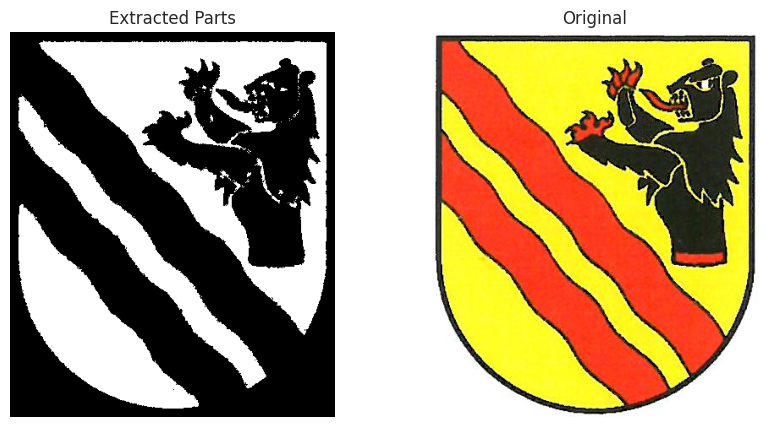

In [54]:
_ = calculate_color_ratio(Path.cwd() / 'raw_data' / 'coat_of_arms' / '1007.jpg',
                      yellow_start,
                      plot_image=True)

### 2.3. Extract Restaurants per Inhabitant

The calculation for Restaurants per Inhabitant is done after merging, since the corresponding number of inhabitants for a commune is easier to get. Hence, here just the `"Anzahl Restaurants"`
feature is extracted from the original DataFrame.

In [27]:
df_rest_count = df_rest_count.loc[:, ["Anzahl Restaurants"]]

### 2.4. Get Dogs per Inhabitants

The number of dogs per 100 inhabitant is extracted, since this is the only feature from the dogs DataFrame which is needed for the ranking.

In [28]:
dogs_per_inh = df_dogs.loc[:, ["Anzahl Hunde pro 100 Einwohner"]]

### 2.5. Merge all DataFrames

All DataFrames are merged using their index (`Gemeindecode`) with a left join. This approach ensures that only communes present in the base dataset are included, since communes missing from it would not have complete data. However, such cases should not occur in the persisted data.

To help create and manipulated the ranking, the Minimum, Median and Maximum values, as well as the values for Romoos and some neighbor communes is displayed. 

In [29]:
lu_data = base_data.join(df_color_ratio, on='Gemeindecode', how='left')
lu_data = lu_data.join(dogs_per_inh, on='Gemeindecode', how='left')
lu_data = lu_data.join(df_rest_count, on='Gemeindecode', how='left')

# add Restaurants per 1000 inhabitants
lu_data["Anzahl Restaurants pro 1000 Einwohner"] = lu_data.apply(
    lambda row: (row["Anzahl Restaurants"] / row["Einwohner"]) * 1000,
    axis=1
)

print("-- Min Values --")
display(lu_data.min())
print("-- Median Values --")
display(lu_data.median(numeric_only=True))
print("-- Max Values --")
display(lu_data.max())
lu_data.loc[lu_data.Gemeindename.isin(['Entlebuch', 'Romoos', 'Hasle', 'Hergiswil bei Willisau'])]

-- Min Values --


Gemeindename                                Adligenswil
Einwohner                                           401
Bevölkerungsdichte pro km²                    17.625033
0-19 Jahre                                    14.454482
20-64 Jahre                                   55.054945
65 Jahre und mehr                             10.972569
Gesamtfläche in km²                                1.08
Siedlungsfläche in %                           2.088353
Landwirtschaftsfläche in %                    25.299145
Wald und Gehölze in %                           9.09971
Leerwohnungsziffer                             0.230947
Neu gebaute Wohnungen pro 1000 Einwohner            0.0
Rotanteil Wappen                                    0.0
Gelbanteil Wappen                                   0.0
Anzahl Hunde pro 100 Einwohner                      0.0
Anzahl Restaurants                                    0
Anzahl Restaurants pro 1000 Einwohner               0.0
dtype: object

-- Median Values --


Einwohner                                   2702.500000
Bevölkerungsdichte pro km²                   245.425054
0-19 Jahre                                    22.414906
20-64 Jahre                                   61.405851
65 Jahre und mehr                             15.886472
Gesamtfläche in km²                           11.060000
Siedlungsfläche in %                          10.593123
Landwirtschaftsfläche in %                    62.967495
Wald und Gehölze in %                         22.637119
Leerwohnungsziffer                             1.287106
Neu gebaute Wohnungen pro 1000 Einwohner       6.638904
Rotanteil Wappen                               0.181453
Gelbanteil Wappen                              0.003587
Anzahl Hunde pro 100 Einwohner                 6.550000
Anzahl Restaurants                             3.000000
Anzahl Restaurants pro 1000 Einwohner          1.099474
dtype: float64

-- Max Values --


Gemeindename                                       Zell
Einwohner                                         82257
Bevölkerungsdichte pro km²                  2826.701031
0-19 Jahre                                    26.742712
20-64 Jahre                                   69.347496
65 Jahre und mehr                             27.032662
Gesamtfläche in km²                              108.17
Siedlungsfläche in %                          51.794872
Landwirtschaftsfläche in %                    80.597015
Wald und Gehölze in %                         60.803213
Leerwohnungsziffer                             7.028754
Neu gebaute Wohnungen pro 1000 Einwohner      30.803907
Rotanteil Wappen                               0.652303
Gelbanteil Wappen                              0.598907
Anzahl Hunde pro 100 Einwohner                     19.6
Anzahl Restaurants                                  233
Anzahl Restaurants pro 1000 Einwohner          7.587253
dtype: object

,Gemeindename,Einwohner,Bevölkerungsdichte pro km²,0-19 Jahre,20-64 Jahre,65 Jahre und mehr,Gesamtfläche in km²,Siedlungsfläche in %,Landwirtschaftsfläche in %,Wald und Gehölze in %,Leerwohnungsziffer,Neu gebaute Wohnungen pro 1000 Einwohner,Rotanteil Wappen,Gelbanteil Wappen,Anzahl Hunde pro 100 Einwohner,Anzahl Restaurants,Anzahl Restaurants pro 1000 Einwohner
Gemeindecode,,,,,,,,,,,,,,,,,
1002,Entlebuch,3280,57.644991,21.798780,59.664634,18.536585,56.90,3.686151,49.552396,42.829559,1.092896,8.446456,0.651710,0.000000,10.0,7,2.134146
1005,Hasle,1736,43.066237,22.695853,59.907834,17.396313,40.31,3.248202,49.094967,39.573518,2.241594,17.694064,0.000000,0.000000,9.2,4,2.304147
1007,Romoos,659,17.625033,22.003035,59.787557,18.209408,37.39,2.088353,35.796519,60.803213,0.874636,0.000000,0.299652,0.444844,19.6,5,7.587253
1132,Hergiswil bei Willisau,1905,60.784939,24.199475,58.320210,17.480315,31.34,4.626675,58.200383,36.407147,1.591187,1.572327,0.011910,0.036574,12.9,2,1.049869


## 3. Create Ranking

To manipulate the ranking in favor of Romoos, and against Hasle and Hergiswil bei Willisau, the following steps were applied:

1. As a first step, columns where Romoos exhibits notably high or low values were selected (e.g. `Wald und Gehölze in %`, `Neu gebaute Wohnungen pro 1000 Einwohner`, `Anzahl Hunde pro 100 Einwohner`).

2. Calculate values on a per inhabitant basis, since Romoos has a relatively low number of inhabitants which often places it in the top places when dividing by the number of inhabitants (e.g. `Anzahl Restaurants pro 1000 Einwohner`, `Anzahl Hunde pro 100 Einwohner`, `Neu gebaute Wohnungen pro 1000 Einwohner`)

In [55]:
def rank_normalized(values_to_rank: pd.Series, less_is_better: bool = False) -> pd.Series:
    '''
    Ranks a ``pd.Series`` by linearly scaling its values to a range from
    0 to 100 points.

    Parameters
    ----------
    values_to_rank : pd.Series
        The values to rank.
    less_is_better : bool, default
        Inverts the ranking when set to ``True``, so that the lowest value
        gets 100 points.
    
    Returns
    -------
    pd.Series
        A pandas Series containing the score for each input value. 
    '''
    value_range = values_to_rank.max() - values_to_rank.min()
    scaled_value = (values_to_rank - values_to_rank.min()) / value_range

    if less_is_better:
        scaled_value = 1 - scaled_value

    return (scaled_value * 100).round().astype('int')

def rank_log_scaled(values_to_rank: pd.Series,
                    less_is_better: bool = False,
                    threshold = None) -> pd.Series:
    '''
    Creates a ranking by applying the rank_normalized function after
    log scaling the ``values_to_rank``.

    Parameters
    ----------
    values_to_rank : pd.Series
        The values to rank.
    less_is_better : bool, default
        Inverts the ranking when set to ``True``, so that the lowest value
        gets 100 points.
    threshold :  float
        Defines which values are too small and should receive 0 points.
        It is applied after the log scaling step.
    
    Returns
    -------
    pd.Series
        A pandas Series containing the score for each input value. 
    '''
    ranking = values_to_rank.copy()
    ranking = ranking.apply(lambda x: np.log(x+1))
    ranking = rank_normalized(ranking, less_is_better=less_is_better).round().astype('int')

    if threshold:
        too_small_mask = ranking.apply(lambda val: val <= threshold)
        ranking.loc[too_small_mask] = 0

    return ranking

def rank_threshold(values_to_rank: pd.Series, threshold: float) -> pd.Series:
    '''
    Ranks a ``pd.Series`` using a threshold.

    This function assigns each element in ``values_to_rank`` a score from
    0 to 100 points. Values that are ``>= threshold`` will receive 0 points,
    while values above the ``threshold`` are ranked linearly. 
    
    Parameters
    ----------
    values_to_rank : pd.Series
        The values to rank.
    threshold :  float
        Defines which values are too small and should receive 0 points.

    Returns
    -------
    pd.Series
        A pandas Series containing the score for each input value. 
    '''
    ranking = values_to_rank.copy()

    # score linearly
    value_range = values_to_rank.max() - threshold
    scaled_value = (values_to_rank - threshold) / value_range
    ranking = 100 * scaled_value

    # values smaller than or equal to the threshold 
    too_small_mask = values_to_rank.apply(lambda val: val <= threshold)
    ranking.loc[too_small_mask] = 0

    return ranking.round().astype('int')

def rank_color(values_to_rank: pd.Series, winning_range: Tuple[float, float]) -> pd.Series:
    '''
    Ranks a ``pd.Series`` containing color rations in range [0,1] using a
    custom winning range.
    
    This function assigns each element in ``values_to_rank`` a score
    from 0 to 100 points. Values within the ``winning_range`` receive 100 points, while
    values outside the range are assigned scores that decrease linearly.  The rate of
    decrease depends on the position of the winning range relative to the overall
    distribution of the ``values_to_rank``. Generally, the rate of decrease is smaller
    for larger outside ranges.
    
    Parameters
    ----------
    values_to_rank : pd.Series
        The color values in in range [0, 1] to create the ranking for.
    winning_range :  Tuple[float, float]
        Values which lie in the ``winning_range`` receive 100 points.
        Both the lower and the upper bound are included in the range.

    Returns
    -------
    pd.Series
        A pandas Series containing the score for each input value. 
    '''

    ranking = values_to_rank.copy()

    # values in the winning range
    win_mask = values_to_rank.loc[(values_to_rank >= winning_range[0]) & (values_to_rank <= winning_range[1])].index
    ranking.loc[win_mask] = 100

    # values smaller then the winning range
    low_mask = values_to_rank.loc[values_to_rank < winning_range[0]].index
    ranking.loc[low_mask] = 100 * (values_to_rank[low_mask]) / (winning_range[0])

    # values larger then the winning range
    high_mask = values_to_rank.loc[values_to_rank > winning_range[1]].index
    ranking.loc[high_mask] = 100 * (1 - values_to_rank[high_mask]) / (1 - winning_range[1])
    
    return ranking.astype('int')

### 3.1. Verify Ranking Function

Check if `rank_color()` returns the desired values for different `winning_range` arguments.

In [31]:
values = pd.Series([0.65, 0.125, 1, 0.5])
assert (rank_color(values, (0.25, 0.3))
        == np.array([50, 50, 0, 71])
).all(), 'Values of rank_custom do not match the desired results.'

values2 = pd.Series([0, 1, 0.225, 0.775])
assert (rank_color(values2, (0.45, 0.55))
        == np.array([0, 0, 50, 50])
).all(), 'Values of rank_custom do not match the desired results.'

### 3.2. Create Ranking

In [32]:
lu_ranked = lu_data.loc[:, ['Gemeindename']].copy()

lu_ranked['Punkte Waldanteil'] = lu_data.loc[:, 'Wald und Gehölze in %'].apply(
    rank_threshold,
    by_row=False, args=(39,))
lu_ranked['Punkte Neue Wohnungen'] = lu_data.loc[:, 'Neu gebaute Wohnungen pro 1000 Einwohner'].apply(
    rank_log_scaled,
    by_row=False, args=(True, 73))
lu_ranked['Punkte Rotanteil Wappen'] = lu_data.loc[:, 'Rotanteil Wappen'].apply(
    rank_color,
    by_row=False, args=((0.25, 0.3),))
lu_ranked['Punkte Gelbanteil Wappen'] = lu_data.loc[:, 'Gelbanteil Wappen'].apply(
    rank_color,
    by_row=False, args=((0.45, 0.55),))
lu_ranked['Punkte Anzahl Hunde pro Einwohner'] = lu_data.loc[:, 'Anzahl Hunde pro 100 Einwohner'].apply(
    rank_threshold,
    by_row=False, args=(6.0,))
lu_ranked['Punkte Anzahl Restaurants pro Einwohner'] = lu_data.loc[:, 'Anzahl Restaurants pro 1000 Einwohner'].apply(
    rank_threshold,
    by_row=False, args=(1.6,))


lu_ranked['Gesamtpunkte'] = lu_ranked.iloc[:, 1:].apply(lambda row: row.mean(), axis=1)
lu_ranked.sort_values(by='Gesamtpunkte', ascending=False, inplace=True)
lu_ranked['Rang'] = np.arange(1, lu_ranked.shape[0] + 1)
lu_ranked.to_csv('ranks.csv')
lu_ranked

,Gemeindename,Punkte Waldanteil,Punkte Neue Wohnungen,Punkte Rotanteil Wappen,Punkte Gelbanteil Wappen,Punkte Anzahl Hunde pro Einwohner,Punkte Anzahl Restaurants pro Einwohner,Gesamtpunkte,Rang
Gemeindecode,,,,,,,,,
1007,Romoos,100,100,100,98,100,100,99.666667,1
1010,Escholzmatt-Marbach,34,0,66,100,21,12,38.833333,2
1129,Fischbach,0,100,0,100,32,0,38.666667,3
1068,Vitznau,70,0,82,8,1,69,38.333333,4
1121,Alberswil,0,0,88,98,7,24,36.166667,5
...,...,...,...,...,...,...,...,...,...
1100,Schlierbach,0,0,0,0,6,0,1.000000,76
1067,Udligenswil,0,0,1,0,0,0,0.166667,77
1023,Ballwil,0,0,0,0,0,0,0.000000,78


## 4. Plot Results

### 4.1 Ranking Overview


In [33]:
def plot_ranking_overview_with_separation(communes_ranked: pd.DataFrame,
                          top_k: int, bottom_k: int,
                          winner: str,
                          losing_neighbors: List[str],
                          canton_name: str
) -> None:
    '''
    Plots an overview of the ranking showing the overall points as a bar plot.
    To improve legibility, the middle part of the ranking is not displayed.
    Additionally a ``winner`` is highlighted in green and a list of
    ``losing_neighbors`` is marked in red.

    Parameters
    ----------
    communes_ranked : pd.DataFrame
        A DataFrame containing the ranking of communes. Needs columns
        ``Rang``, ``Gesamtpunkte`` and ``Gemeindename``.
    top_k : int
        How many communes from the top of the ranking should be displayed.
    bottom_k : int
        How many communes from the bottom of the ranking should be displayed.
    winner : str
        The name of the winner, which will be highlighted in green.
    losing_neighbors : List[str]
        A list of neighbors, which should be highlighted in red.
    canton_name : str
        The name of the canton the ranking was done in to
        display it in the title.

    Raises
    ------
    ValueError
        If ``top_k`` and ``bottom_k`` are set to plot all values which makes
        the separation unnecessary or more communes are selected than there are
        rows in the DataFrame. 
    '''
    if top_k + bottom_k >= len(communes_ranked) - 1:
        raise ValueError(
            "top_k and bottom_k are set to display more commune values then available "
            + "or no separation is necessary."
        )

    ranked_top = communes_ranked.loc[communes_ranked['Rang'] <= top_k]
    ranked_bottom = communes_ranked.loc[communes_ranked['Rang'] >= len(communes_ranked) - bottom_k]

    fig, (ax_top, ax_bottom) = plt.subplots(
        2, 1,
        sharex=True,
        figsize=(10, 8),
        gridspec_kw={'height_ratios': [len(ranked_top), len(ranked_bottom)]}
    )

    # Subplot for 'Rang' <= top_k
    _ = sns.barplot(ranked_top, x='Gesamtpunkte', y='Gemeindename', ax=ax_top)
    ytick_lables_top = [t.get_text() for t in ax_top.get_yticklabels()]

    # Subplot for the bottom_k
    _ = sns.barplot(ranked_bottom, x='Gesamtpunkte', y='Gemeindename', ax=ax_bottom)
    ytick_lables_bottom = [t.get_text() for t in ax_bottom.get_yticklabels()]

    # Add break symbols
    x = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
    y_top = [1, 0.98, 1.02, 0.98, 1.02, 0.98, 1]
    y_bottom = [0, 0.02, -0.02, 0.02, -0.02, 0.02, 0]
    ax_top.plot(x, y_bottom, transform=ax_top.transAxes, color='k')
    ax_bottom.plot(x, y_top, transform=ax_bottom.transAxes, color='k')

    # Iterate over the bars and corresponding labels to highlight winner
    # and the loosing neighbors
    for bar, label in zip(ax_top.patches, ytick_lables_top):
        if label == winner:
            bar.set_facecolor('palegreen')
    for bar, label in zip(ax_bottom.patches, ytick_lables_bottom):
        if label in losing_neighbors:
            bar.set_facecolor('salmon')
    
    # Add the rank to the bars in the top plot
    for bar, rank in zip(ax_top.patches, ranked_top['Rang']):
        ax_top.text(
            bar.get_width() + 1,  # x-coordinate
            bar.get_y() + bar.get_height() / 2,  # y-coordinate
            f'{rank}.',
            va='center'
        )

    # Add the rank to the bars in the bottom plot
    for bar, rank in zip(ax_bottom.patches, ranked_bottom['Rang']):
        ax_bottom.text(
            bar.get_width() + 1,  # x-coordinate
            bar.get_y() + bar.get_height() / 2,  # y-coordinate
            f'{rank}.',
            va='center'
        )

    # remove ylabels
    ax_top.set_ylabel('')
    ax_bottom.set_ylabel('')

    fig.suptitle(f'Gemeinde Ranking Kanton {canton_name}', fontsize=16)
    plt.tight_layout()

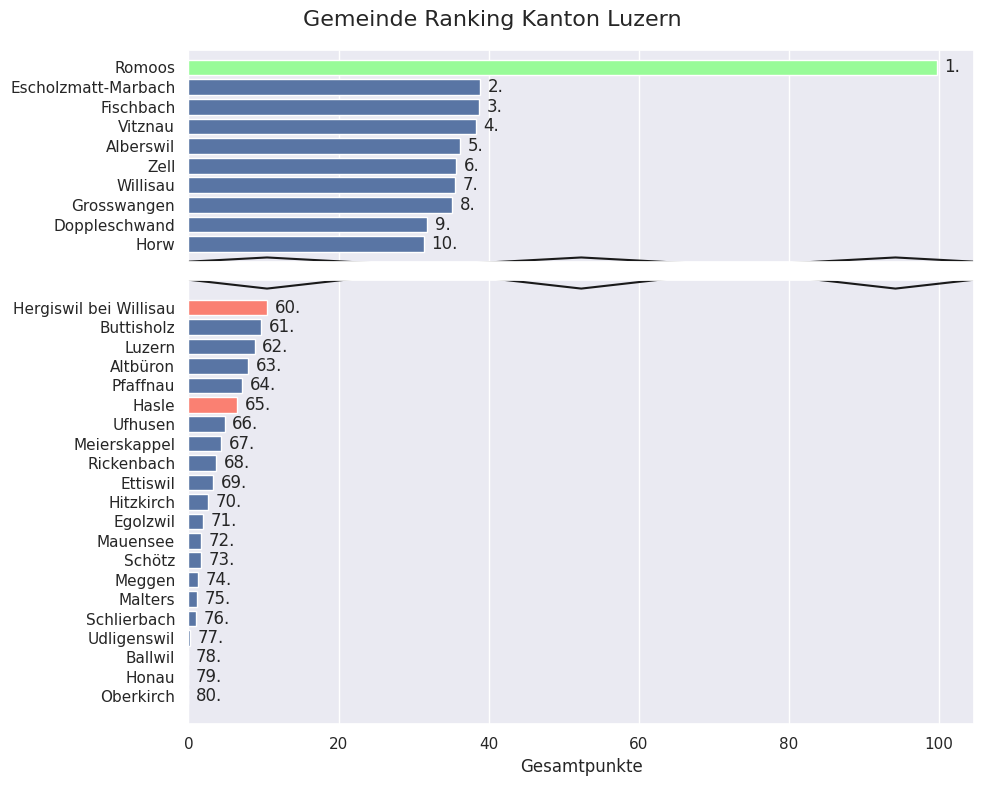

In [34]:
plot_ranking_overview_with_separation(
    lu_ranked, top_k=10, bottom_k=20,
    winner='Romoos', 
    losing_neighbors=['Hergiswil bei Willisau', 'Hasle'],
    canton_name="Luzern"
)

### 4.2. Plot Restaurants per Inhabitant for all Communes

In [35]:
def plot_values_per_area(
        area: geopandas.GeoDataFrame,
        values: pd.DataFrame,
        areas_of_interest: List[str],
        locations: geopandas.GeoDataFrame | None = None,
) -> None:
    '''Plots a comparison of the ``values`` for the ``area`` of all
    commune on a map.
    
    Parameters
    ----------
    area : GeoDataFrame
        The areas of the communes to display.
    values : pd.DataFrame
        A DataFrame that contains values for all rows in ``area``.
    areas_of_interest : List[str]
        A list of the names of communes, which should be marked using
        a dot and labelled with their name.
    locations: geopandas.GeoDataFrame, optional
        A GeoDataframe containing locations to show on the map.
    '''
    areas_and_values = area.copy()
    areas_and_values = areas_and_values.merge(values, how='inner', left_on='gemeinde.BFS_NUMMER', right_index=True)

    # undo coordinate reversing for plot
    areas_and_values['geometry'] = areas_and_values.loc[:, 'geometry'].apply(
        lambda polygon: transform(lambda x, y: (y, x), polygon)
    )

    fig, ax = plt.subplots(figsize=(10, 12))

    areas_and_values.plot(
        column='Anzahl Restaurants pro 1000 Einwohner',
        legend=True,
        legend_kwds={"label": "Anzahl Restaurants pro 1000 Einwohner", "orientation": "horizontal"},
        cmap='GnBu',
        ax=ax,
    )

    if locations is not None:
        # coordinate reversing for plot
        locations['Point'] = locations.loc[:, 'Point'].apply(
            lambda coord: transform(lambda x, y: (y, x), coord)
        )
        locations.plot(ax=ax, marker='o', color='red', markersize=5)

    ax.set_axis_off()
    fig.suptitle("Überblick Anzahl Restaurants Kanton Luzern")


    # Foreach area of interest: add a text label at the centroid
    centroids = []
    for _, row in areas_and_values.loc[areas_and_values['gemeinde.NAME'].isin(areas_of_interest)].iterrows():
        # Calculate the centroid of the geometry
        centroid = row.geometry.centroid
        centroids.append(centroid)
        # Place the text at the centroid coordinates with centered alignment
        ax.text(centroid.x, centroid.y - 0.01, row['gemeinde.NAME'],
                fontsize=10, fontweight='bold', ha='center', va='center', color='black')
    
    # Show centroids
    ax.scatter(
        x=list(map(lambda p: (p.x), centroids)),
        y=list(map(lambda p: (p.y), centroids)),
        marker='o', color='coral')

    plt.tight_layout()

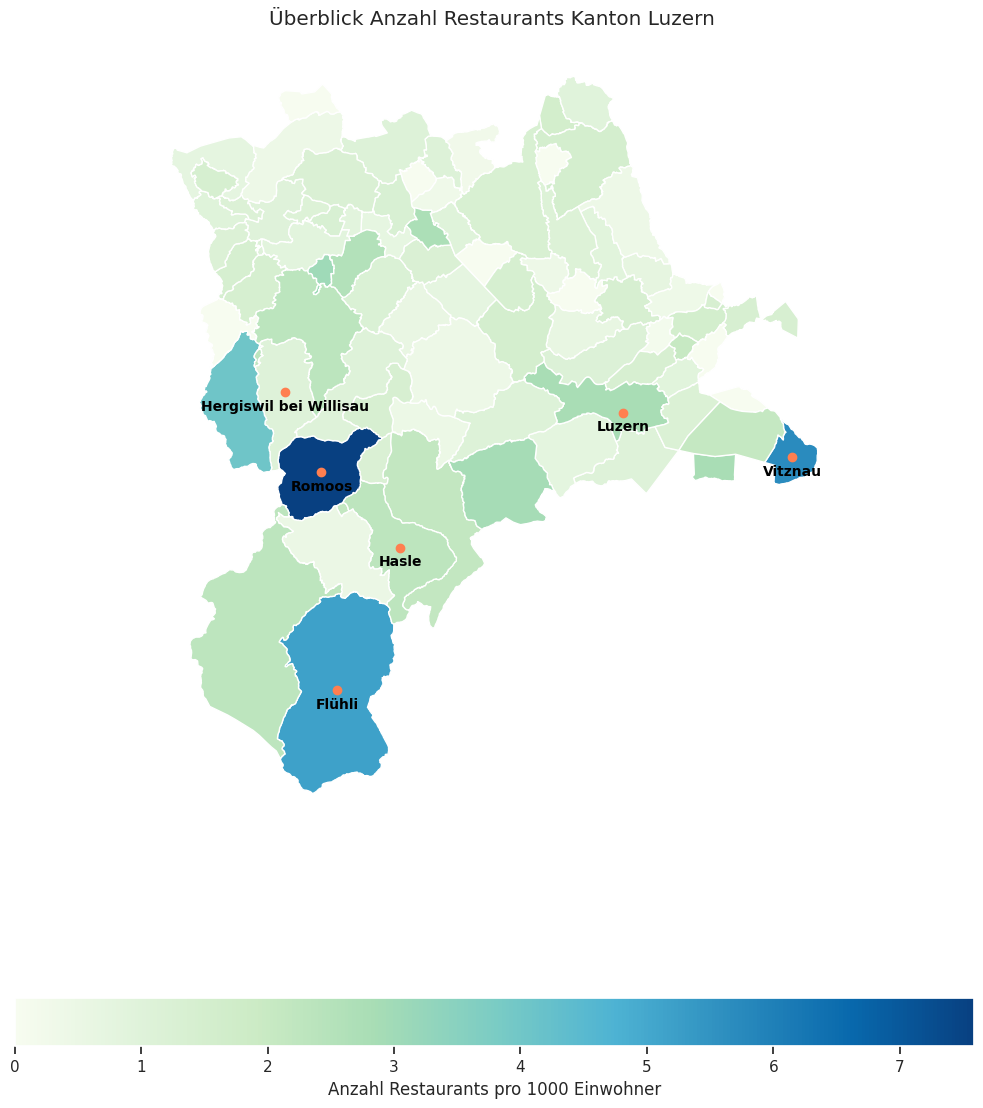

In [36]:
plot_values_per_area(
    area=df_communes_area,
    values=lu_data.loc[:, ['Anzahl Restaurants pro 1000 Einwohner']],
    areas_of_interest=['Romoos', 'Hasle', 'Hergiswil bei Willisau', 'Luzern', 'Flühli', 'Vitznau'],
)

### 4.3. Additional Folium Map to explore Areas

In [37]:
# folium map, centered in Romoos
folium_map = folium.Map(
    location=[47.011163,8.028080],
    zoom_start=12,
    tiles="OpenStreetMap"
)

# replace gemeinde.BFS_NUMMER with gemeinde_BFS_NUMMER
# since folium cannot handle it
folium_json_string = filter_geojson_for_lu(BOUNDARIES_PATH).replace(
    'gemeinde.BFS_NUMMER', 
    'gemeinde_BFS_NUMMER'
)

# add the geojson for canton lucerne to the map
geojson_map = folium.GeoJson(
        folium_json_string,
        style_function=lambda _: {
            'fillColor': 'black',
            'color': 'black',
            'weight': 2,
            'fill_opacity': 0.4,
        }
    )
geojson_map.add_to(folium_map)

folium_map